In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Posterior EmisCH4 (Oil / Gas)  ×  OGIM (refineries / fields / basins / flares)
створює PNG-карти в папці maps/.
"""

# ---------------------------- імпорти --------------------------------------
from pathlib import Path
import numpy as np, xarray as xr, yaml
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import cartopy.crs as ccrs, cartopy.feature as cf
import colorcet as cc

# ---------------------------- налаштування ---------------------------------
BASE      = Path("/home/hermit/imi_output_dir")
PERIODS   = ["PreWar_SepOct2021","WarOnset_FebMar2022",
             "WarOnset_MayJun2022","War_FebMar2023","War_JunJul2023"]
SECTORS   = ["Oil","Gas"]
SHOW_BASINS = True                # вимкніть, якщо забагато контурів
OUTDIR    = Path("maps")          ; OUTDIR.mkdir(exist_ok=True)

# ---------- області (контур) ----------------------------------------------
GDF_OBL = gpd.read_file("regions.shp").to_crs(4326)
UKR_EXT = [*GDF_OBL.total_bounds]   # minx,miny,maxx,maxy
UKR_EXT = [UKR_EXT[0]-1, UKR_EXT[2]+1, UKR_EXT[1]-1, UKR_EXT[3]+1]

# ---------- OGIM -----------------------------------------------------------
def load_ogim():
    gpkg="/home/hermit/imi_output_dir/OGIM_v2.7.gpkg"
    lyr = dict(refineries="Crude_Oil_Refineries",
               flares    ="Natural_Gas_Flaring_Detections",
               fields    ="Oil_and_Natural_Gas_Fields",
               basins    ="Oil_and_Natural_Gas_Basins")
    return {k:gpd.read_file(gpkg,layer=v).query("COUNTRY=='UKRAINE'").to_crs(4326)
            for k,v in lyr.items()}
OGIM = load_ogim()

# ---------- отримати DataArray --------------------------------------------
def posterior_da(period:str, sector:str):
    ds = xr.open_dataset(BASE/period/"inversion/output/netCDF/posterior.nc")
    da = ds[f"EmisCH4_{sector}"]
    if "time" in da.dims: da = da.mean("time")
    return da*1_000**2*3600          # kg km-2 h-1

# ---------- малюнок --------------------------------------------------------
def plot_map(sector, period, save=True, outdir="maps"):
    # 1) завантажити emissions
    da = posterior_da(period, sector)
    vmax = np.nanpercentile(da, 99)

    # 2) створити фігуру з проекцією
    fig, ax = plt.subplots(
        figsize=(10,6),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # 3) фон суші та море - додаємо окремо для кращого контрасту
    # Спочатку додаємо OCEAN для базового фону
    ax.add_feature(cf.OCEAN.with_scale("50m"), facecolor="lightblue", zorder=0)
    
    # Потім LAND як основний контур суші
    ax.add_feature(cf.LAND.with_scale("50m"), facecolor="lightgray", 
                  edgecolor="black", linewidth=0.5, zorder=1)
    
    # Потім окремо берегову лінію з більшою чіткістю
    ax.coastlines(resolution="50m", linewidth=1.0, color="black", zorder=3)

    # 4) растрова карта викидів
    da.plot.pcolormesh(
        ax=ax, cmap="Spectral_r",
        vmin=0, vmax=vmax, shading="auto",
        cbar_kwargs={"label":"kg km⁻² h⁻¹"},
        zorder=2
    )

    # 5) кордони областей
    GDF_OBL.boundary.plot(ax=ax, color="k", linewidth=0.5, zorder=4)

    # 6) OGIM – завжди додаємо fields і basins
    OGIM["fields"].plot(
        ax=ax, facecolor="none", edgecolor="pink",
        linewidth=0.8, zorder=5
    )
    if SHOW_BASINS:
        OGIM["basins"].plot(
            ax=ax, facecolor="none", edgecolor="cyan",
            linewidth=0.7, zorder=5
        )

    # 7) секторні точки
    if sector == "Oil":
        # refinery
        r = OGIM["refineries"]
        ax.scatter(
            r.geometry.x, r.geometry.y,
            marker="^", s=30, color="red",
            edgecolor="k", label="refinery", zorder=6
        )
    else:  # Gas
        f = OGIM["flares"]
        ax.scatter(
            f.geometry.x, f.geometry.y,
            marker="*", s=60, color="turquoise",
            edgecolor="k", label="flare", zorder=6
        )

    # 8) побудова легенди
    handles, labels = ax.get_legend_handles_labels()
    # проксі для field та basin
    field_proxy = mpatches.Patch(facecolor='none',
                                 edgecolor='pink',
                                 linewidth=0.8,
                                 label='Oil/gas field')
    basin_proxy = mpatches.Patch(facecolor='none',
                                 edgecolor='cyan',
                                 linewidth=0.7,
                                 label='Oil/gas basin')
    handles += [field_proxy, basin_proxy]
    labels  += ['Oil/gas field', 'Oil/gas basin']

    # встановити легенду
    leg = ax.legend(handles=handles, labels=labels,
                    loc="lower left", framealpha=0.8)
    for txt in leg.get_texts():
        txt.set_path_effects([pe.withStroke(linewidth=2,
                                            foreground="white")])

    # 9) координатна сітка
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                     linestyle="--", linewidth=0, alpha=0.6)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}

    # 10) оформлення
    ax.set_title(f"{sector} – OGIM – {period.split('_',1)[1]}",
                 fontsize=16)
    ax.set_extent(UKR_EXT)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # 11) зберегти
    if save:
        Path(outdir).mkdir(exist_ok=True)
        fn = Path(outdir)/f"{sector}_{period}.png"
        fig.savefig(fn, dpi=200, bbox_inches="tight")
        print("saved", fn)

    plt.show()

saved maps/Oil_PreWar_SepOct2021.png


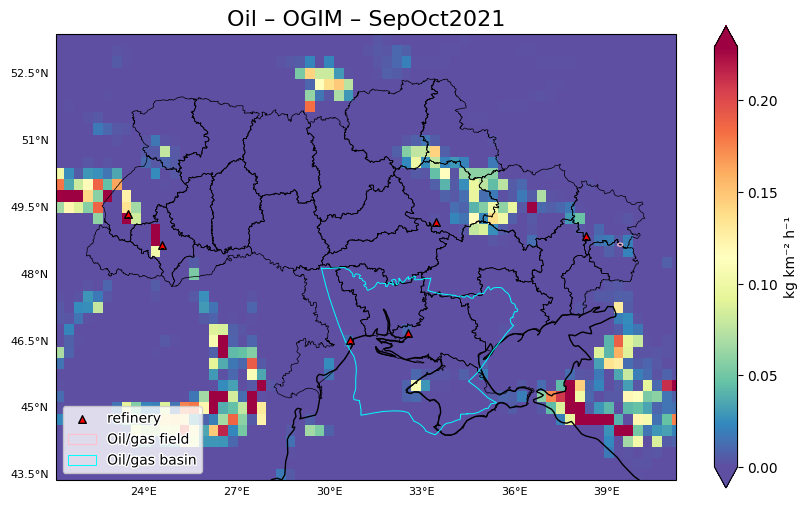

saved maps/Oil_WarOnset_FebMar2022.png


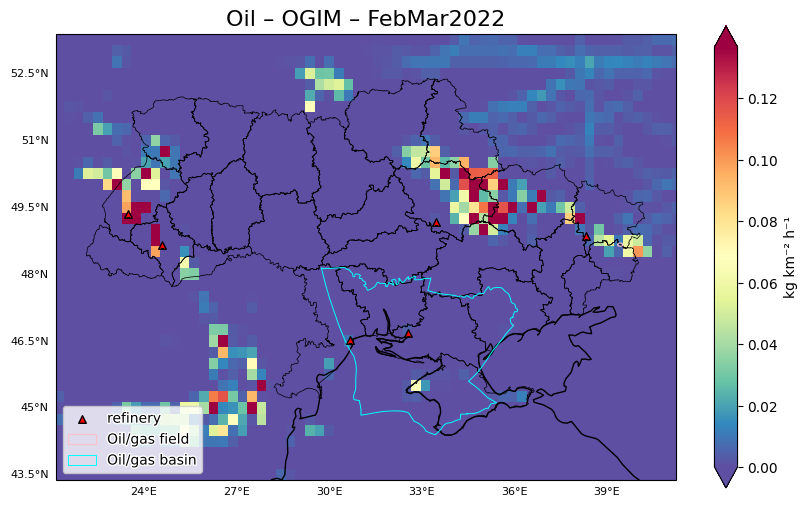

saved maps/Oil_WarOnset_MayJun2022.png


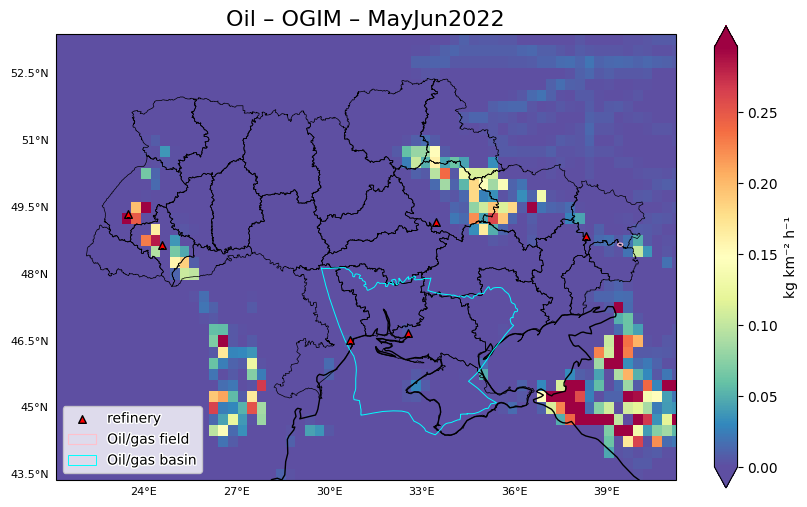

saved maps/Oil_War_FebMar2023.png


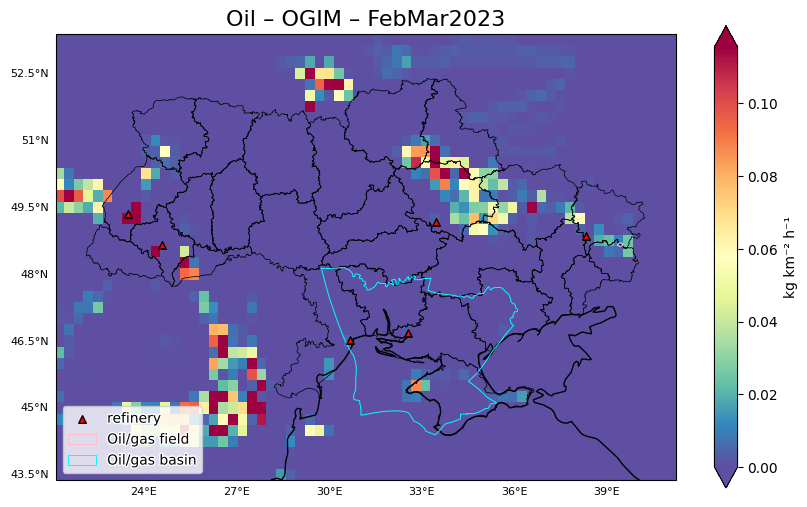

saved maps/Oil_War_JunJul2023.png


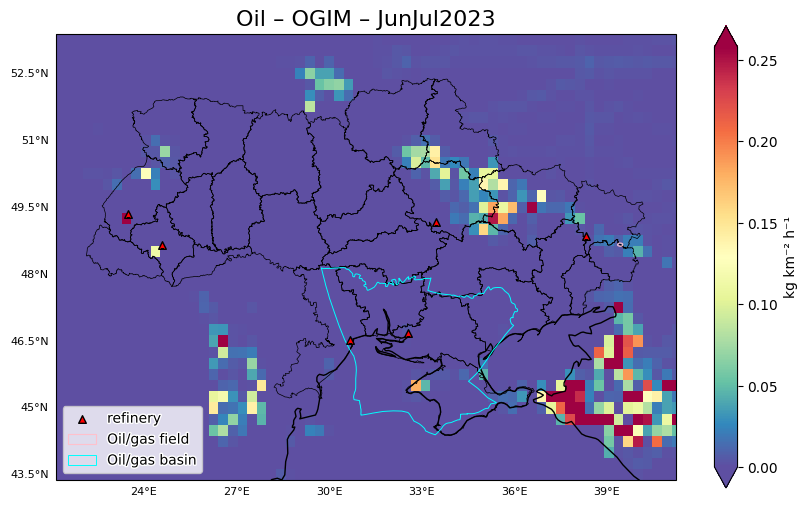

saved maps/Gas_War_JunJul2023.png


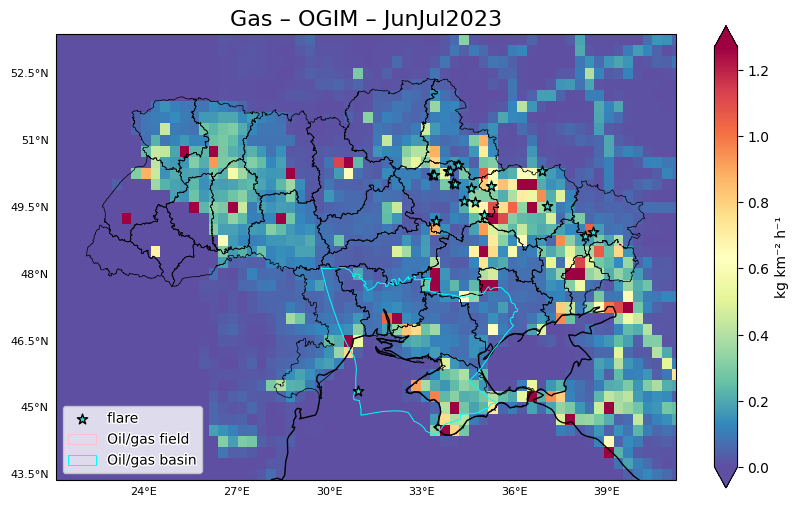

In [2]:
# ---------- запуск ---------------------------------------------------------
if __name__ == "__main__":
    for sec in SECTORS:
        for per in PERIODS:
            # фаєри – тільки у червень/липень 2023
            if sec=="Gas" and not per.endswith("JunJul2023"):
                continue
            plot_map(sec, per)